# Reimplementing CanICA without nilearn.decompistion.canICA

In [142]:
%matplotlib inline

In [143]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=30,data_dir='/home/share/TmpData/Qinglin/nilearn_data/')
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

First functional nifti image (4D) is at: /home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/usr/local/lib/python3.5/dist-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [144]:
from nilearn._utils.niimg_conversions import _resolve_globbing
imgs = _resolve_globbing(func_filenames)

In [145]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(func_filenames)

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="nilearn_cache", 
                     memory_level=2)
fmri_masked = masker.fit()

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='nilearn_cache'", use "location='nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)


In [146]:
from nilearn.decomposition.base import mask_and_reduce

data = mask_and_reduce(
    masker, imgs, confounds=None,
    reduction_ratio=0.1,
    random_state=0,
    memory="nilearn_cache",
    memory_level=3,
    n_jobs=8)

In [147]:
print(data.shape)

(534, 63782)


In [148]:
from sklearn.decomposition import dict_learning_online
dictionary, components=dict_learning_online(data,n_components=30, 
                                            alpha=10,shuffle=1,
                                            batch_size=20,n_iter=100,method="cd",
                                            verbose=1)


[dict_learning] ....................................................................................................| 

In [149]:
test=components

In [150]:
components=test
from scipy import stats
#components=stats.zscore(components,axis=1)

import numpy as np
from scipy.stats import scoreatpercentile

abs_components = np.abs(components)
ratio=100. - (100. / len(components)) *3
threshold = scoreatpercentile(abs_components,ratio)
components[abs_components < threshold] = 0

for component in components:

    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


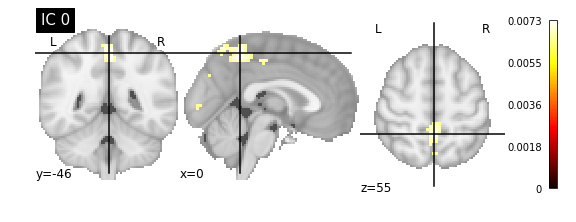

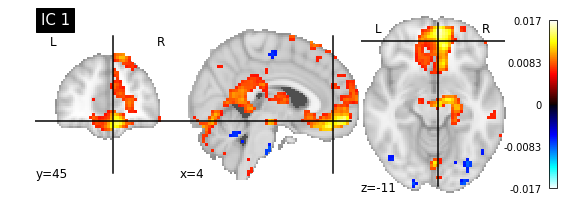

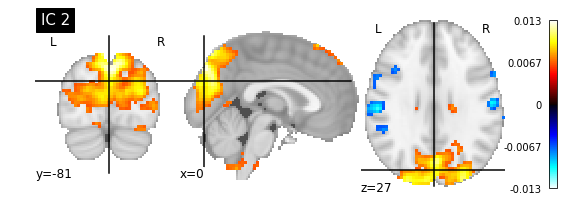

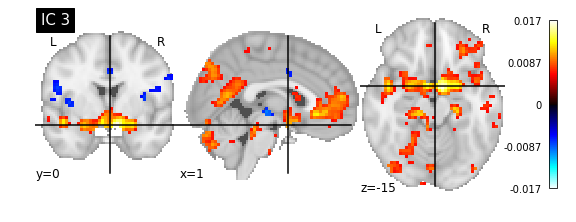

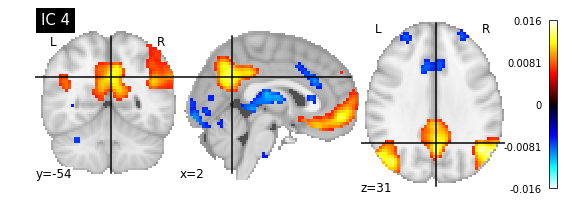

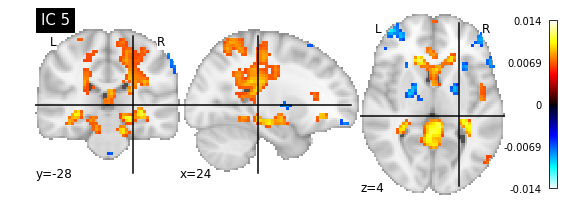

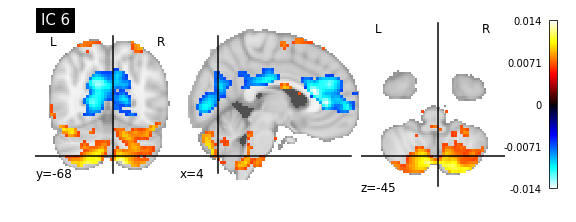

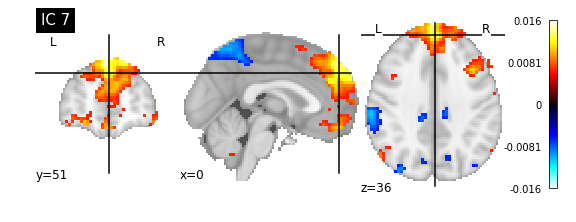

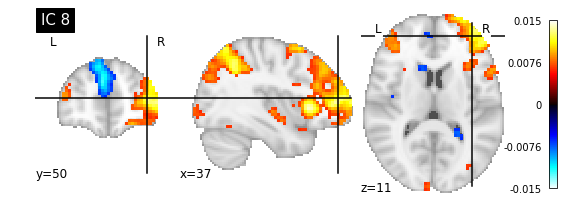

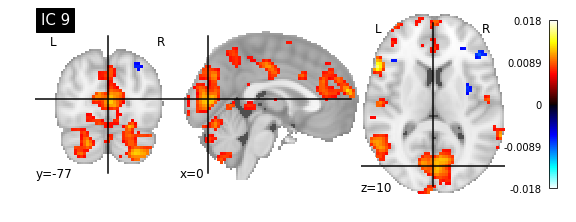

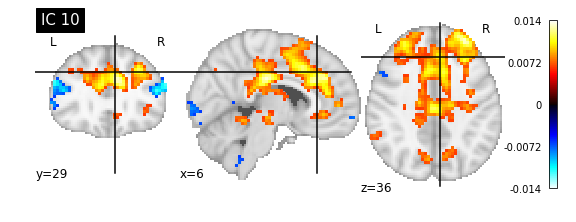

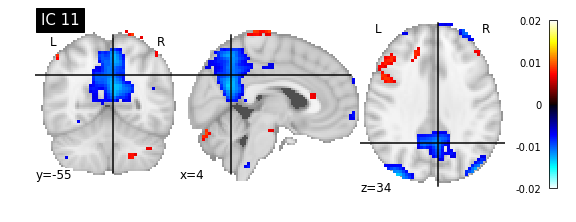

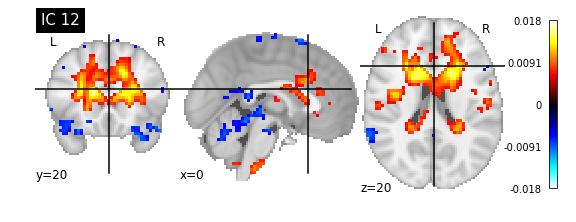

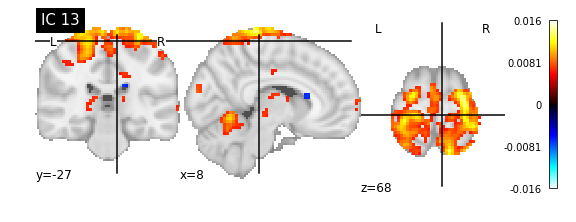

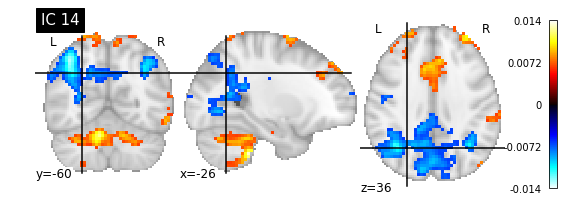

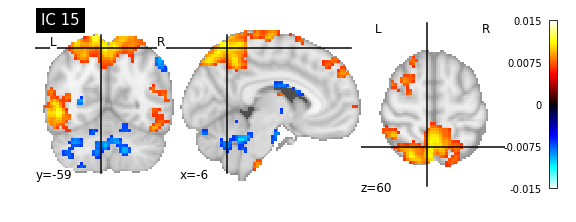

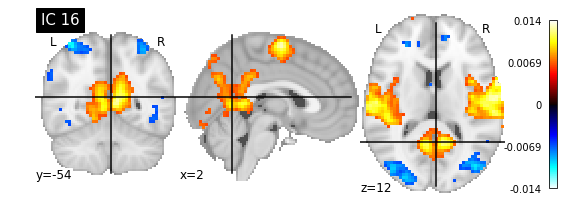

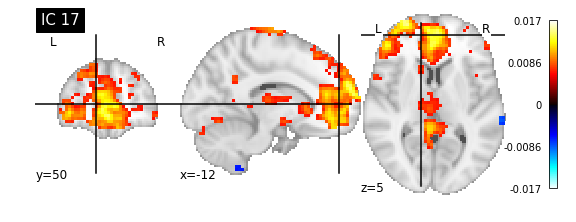

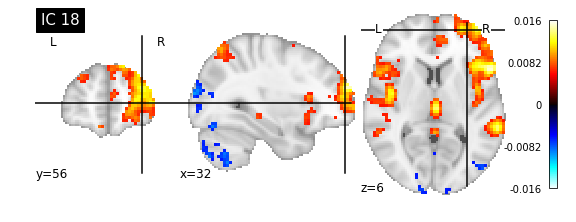

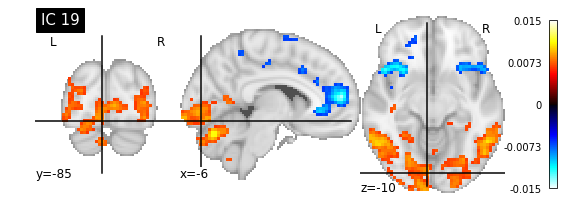

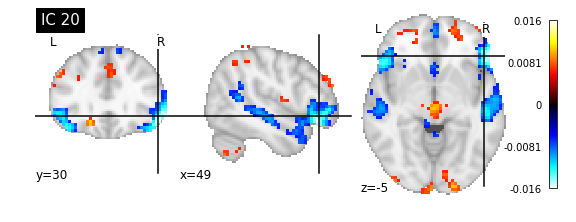

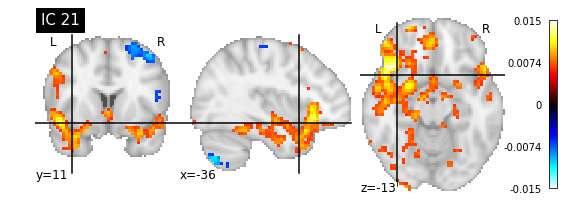

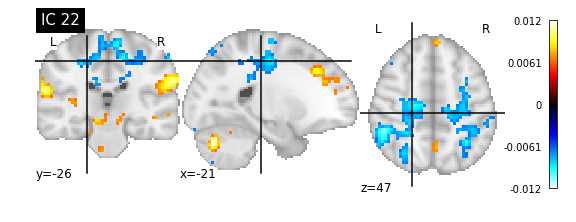

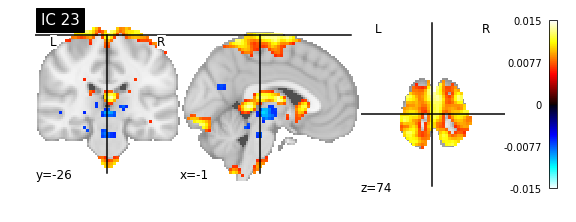

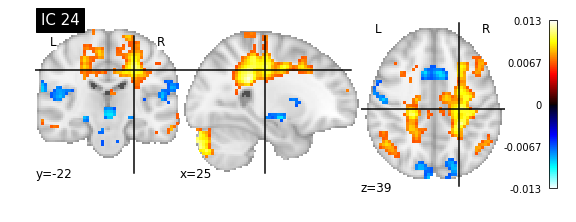

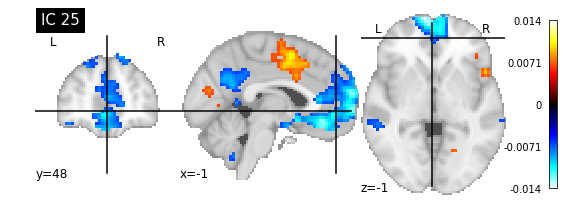

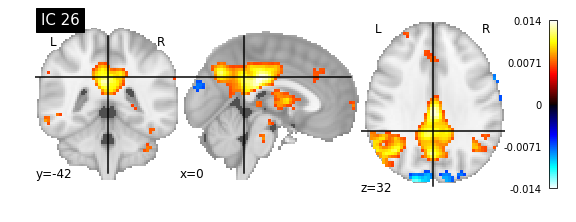

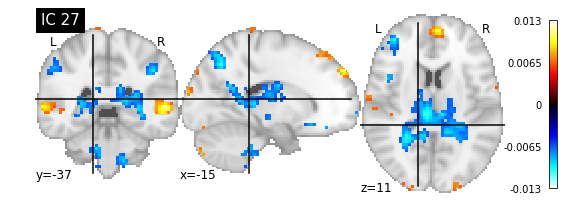

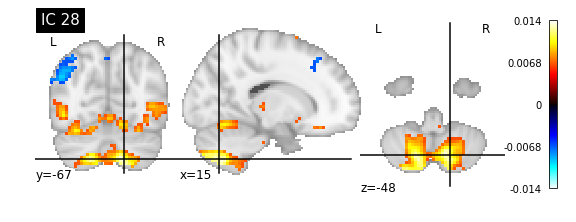

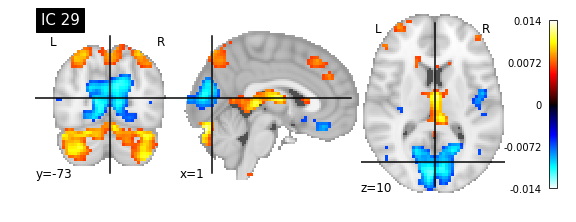

In [151]:
#components_img=[masker.inverse_transform(component) for component in components]
components_img=masker.inverse_transform(components)

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()